<a href="https://colab.research.google.com/github/shrprabh/BraTS-PolypSegmentation/blob/test1000/polysegmentationofbradtsdataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install nibabel for handling NIfTI files


In [3]:
!pip install nibabel

# Import libraries


In [4]:
import os
import numpy as np
import nibabel as nib
import cv2
import matplotlib.pyplot as plt
from glob import glob
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Conv2DTranspose,
                                     BatchNormalization, Activation, Concatenate)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# importing files files package to upload a file to get the dataset

In [5]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"shrprabh","key":"323ee59f3e2f0c11df48be77bdb30712"}'}

In [6]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d awsaf49/brats2020-training-data


Dataset URL: https://www.kaggle.com/datasets/awsaf49/brats2020-training-data
License(s): CC0-1.0
brats2020-training-data.zip: Skipping, found more recently modified local copy (use --force to force download)


In [7]:
!kaggle datasets download -d awsaf49/brats2020-training-data
!unzip -qq brats2020-training-data.zip -d brats2020


Dataset URL: https://www.kaggle.com/datasets/awsaf49/brats2020-training-data
License(s): CC0-1.0
brats2020-training-data.zip: Skipping, found more recently modified local copy (use --force to force download)
replace brats2020/BraTS20 Training Metadata.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
N
n


#Step 3: Data Preprocessing
#Load the images and masks, extract slices, and prepare them for training.#

#load libraries

In [8]:
import os
import h5py
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose,
                                     BatchNormalization, Activation, Dropout)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [9]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Nov 30 07:11:56 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   30C    P0              41W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

# Define your data directory



In [10]:
data_dir = 'brats2020/BraTS2020_training_data/content/data/'


# Initialize lists to store image and mask slices


In [11]:
image_slices = []
mask_slices = []

In [12]:
file_list = [f for f in os.listdir(data_dir) if f.endswith('.h5')][:3000]


# Loop over each .h5 file in the directory (only first 1000)


In [13]:
for file_name in file_list:
    file_path = os.path.join(data_dir, file_name)

    # Open the .h5 file and load the data
    with h5py.File(file_path, 'r') as f:
        # Assuming 'image' and 'mask' are keys for image and mask data in the .h5 files.
        img_slice = np.array(f['image'])
        mask_slice = np.array(f['mask'])

        # Skip files where the mask is completely black
        if np.max(mask_slice) == 0:
            continue  # Skip this slice as it contains no segmentation region

        # Normalize image slice safely (add epsilon to avoid division by zero)
        epsilon = 1e-8
        img_slice = (img_slice - img_slice.min()) / (img_slice.max() - img_slice.min() + epsilon)

        # Resize image and mask to 256x256 for DUCKNet input
        img_resized = cv2.resize(img_slice, (256, 256), interpolation=cv2.INTER_LINEAR)
        mask_resized = cv2.resize(mask_slice, (256, 256), interpolation=cv2.INTER_NEAREST)

        # Threshold the mask to ensure binary values (0 or 1)
        mask_resized = (mask_resized > 0.5).astype(np.float32)

        # Ensure the images are in the correct shape and data type
        if img_resized.ndim == 2:
            img_resized = np.expand_dims(img_resized, axis=-1)
        else:
            img_resized = img_resized[..., :1]  # Use the first channel

        if mask_resized.ndim == 2:
            mask_resized = np.expand_dims(mask_resized, axis=-1)
        else:
            mask_resized = mask_resized[..., :1]  # Use the first channel

        # Append to lists
        image_slices.append(img_resized)
        mask_slices.append(mask_resized)

# Convert lists to NumPy arrays


In [14]:
X = np.array(image_slices, dtype=np.float32)   # Shape will be (num_samples, 256, 256, 1)
y = np.array(mask_slices, dtype=np.float32)    # Shape will be (num_samples, 256, 256, 1)

# Normalize images to [0,1]
# Note: Masks are already binary (0 or 1) after thresholding

In [15]:
X = np.clip(X, 0, 1)  # Ensure X is in [0, 1]


# Check for invalid data before training


In [16]:
print('Total samples:', X.shape[0])
print('NaN in X:', np.isnan(X).sum(), 'Inf in X:', np.isinf(X).sum())   # Should both be zero
print('NaN in y:', np.isnan(y).sum(), 'Inf in y:', np.isinf(y).sum())   # Should both be zero

Total samples: 1272
NaN in X: 0 Inf in X: 0
NaN in y: 0 Inf in y: 0


# Split data into training and validation sets (80% train, 20% validation)


In [17]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


# Data augmentation parameters for training generator


In [18]:
data_gen_args = dict(horizontal_flip=True,
                     vertical_flip=True,
                     rotation_range=90,
                     fill_mode='nearest')

image_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**data_gen_args)
mask_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**data_gen_args)

batch_size = 8


# Training generator function


In [19]:
def train_generator(X_train_data, y_train_data, batch_size):
    seed_value = 42
    image_generator = image_datagen.flow(X_train_data, batch_size=batch_size, seed=seed_value)
    mask_generator = mask_datagen.flow(y_train_data, batch_size=batch_size, seed=seed_value)
    for img, mask in zip(image_generator, mask_generator):
        yield (img, mask)

train_gen = train_generator(X_train, y_train, batch_size)
steps_per_epoch = len(X_train) // batch_size

# Define DUCKNet architecture with dense blocks


In [20]:
def dense_block(x, filters, kernel_size=3, padding='same', activation='relu'):
    conv1 = Conv2D(filters, kernel_size, padding=padding)(x)
    bn1 = BatchNormalization()(conv1)
    act1 = Activation(activation)(bn1)
    concat1 = concatenate([x, act1], axis=-1)

    conv2 = Conv2D(filters, kernel_size, padding=padding)(concat1)
    bn2 = BatchNormalization()(conv2)
    act2 = Activation(activation)(bn2)
    concat2 = concatenate([x, act1, act2], axis=-1)

    conv3 = Conv2D(filters, kernel_size, padding=padding)(concat2)
    bn3 = BatchNormalization()(conv3)
    act3 = Activation(activation)(bn3)
    return act3
def DUCKNet(input_size=(256, 256, 1)):
    inputs = Input(input_size)

    # Encoder
    # Block 1
    db1 = dense_block(inputs, 64)
    pool1 = MaxPooling2D(pool_size=(2, 2))(db1)

    # Block 2
    db2 = dense_block(pool1, 128)
    pool2 = MaxPooling2D(pool_size=(2, 2))(db2)

    # Block 3
    db3 = dense_block(pool2, 256)
    pool3 = MaxPooling2D(pool_size=(2, 2))(db3)

    # Block 4
    db4 = dense_block(pool3, 512)
    pool4 = MaxPooling2D(pool_size=(2, 2))(db4)

    # Bottom
    db5 = dense_block(pool4, 1024)

    # Decoder
    up6 = Conv2DTranspose(512, 2, strides=(2, 2), padding='same')(db5)
    merge6 = concatenate([up6, db4], axis=-1)
    db6 = dense_block(merge6, 512)

    up7 = Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(db6)
    merge7 = concatenate([up7, db3], axis=-1)
    db7 = dense_block(merge7, 256)

    up8 = Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(db7)
    merge8 = concatenate([up8, db2], axis=-1)
    db8 = dense_block(merge8, 128)

    up9 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(db8)
    merge9 = concatenate([up9, db1], axis=-1)
    db9 = dense_block(merge9, 64)

    conv10 = Conv2D(1, 1, activation='sigmoid')(db9)

    model = Model(inputs=inputs, outputs=conv10)
    return model

# Build and compile the model


In [21]:
model = DUCKNet(input_size=(256, 256, 1))
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# Set up callbacks


In [22]:
callbacks = [
    ModelCheckpoint('ducknet_brats.keras', monitor='val_loss', save_best_only=True),
    EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)
]

# Train the model

In [23]:
history = model.fit(train_gen,
                    steps_per_epoch=steps_per_epoch,
                    epochs=30,
                    validation_data=(X_val, y_val),
                    callbacks=callbacks)

Epoch 1/30
127/127 ━━━━━━━━━━━━━━━━━━━━ 131s 434ms/step - accuracy: 0.7752 - loss: 0.5375 - val_accuracy: 0.9949 - val_loss: 0.5250
Epoch 2/30
127/127 ━━━━━━━━━━━━━━━━━━━━ 42s 165ms/step - accuracy: 0.9928 - loss: 0.2367 - val_accuracy: 0.9949 - val_loss: 0.2676
Epoch 3/30
127/127 ━━━━━━━━━━━━━━━━━━━━ 21s 164ms/step - accuracy: 0.9924 - loss: 0.1963 - val_accuracy: 0.9949 - val_loss: 0.1865
Epoch 4/30
127/127 ━━━━━━━━━━━━━━━━━━━━ 21s 163ms/step - accuracy: 0.9923 - loss: 0.1506 - val_accuracy: 0.9949 - val_loss: 0.1585
Epoch 5/30
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 160ms/step - accuracy: 0.9928 - loss: 0.1210 - val_accuracy: 0.9949 - val_loss: 0.1141
Epoch 6/30
127/127 ━━━━━━━━━━━━━━━━━━━━ 21s 162ms/step - accuracy: 0.9940 - loss: 0.1022 - val_accuracy: 0.9948 - val_loss: 0.0996
Epoch 7/30
127/127 ━━━━━━━━━━━━━━━━━━━━ 21s 162ms/step - accuracy: 0.9934 - loss: 0.0899 - val_accuracy: 0.9949 - val_loss: 0.0863
Epoch 8/30
127/127 ━━━━━━━━━━━━━━━━━━━━ 16s 129ms/step - accuracy: 0.9932 - loss: 

# Get the list of .h5 files and limit it to the first 1000 files


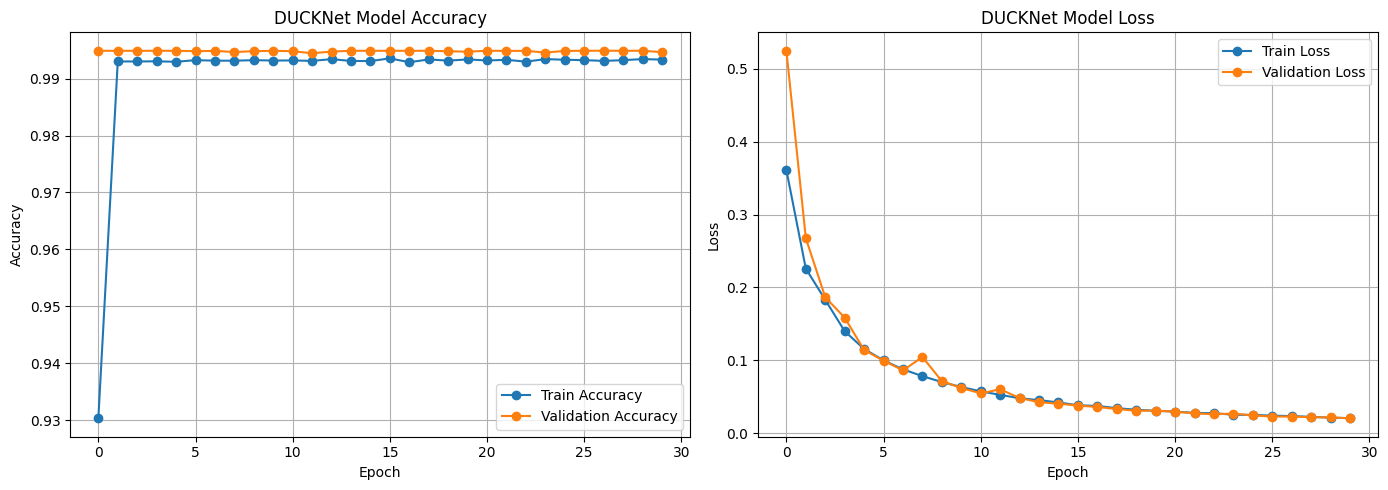

In [24]:
# Plot training & validation accuracy and loss values
import matplotlib.pyplot as plt

# Ensure inline plotting if using Jupyter Notebook
%matplotlib inline

# Plot accuracy
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('DUCKNet Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('DUCKNet Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()


In [25]:
import os

# Create directories for saving images and masks
output_dir = 'output_images'
os.makedirs(f"{output_dir}/train/images", exist_ok=True)
os.makedirs(f"{output_dir}/train/masks", exist_ok=True)
os.makedirs(f"{output_dir}/val/images", exist_ok=True)
os.makedirs(f"{output_dir}/val/masks", exist_ok=True)

# Save training images and masks
for i, (image, mask) in enumerate(zip(X_train, y_train)):
    cv2.imwrite(f"{output_dir}/train/images/image_{i}.png", (image * 255).astype(np.uint8))
    cv2.imwrite(f"{output_dir}/train/masks/mask_{i}.png", (mask * 255).astype(np.uint8))

# Save validation images and masks
for i, (image, mask) in enumerate(zip(X_val, y_val)):
    cv2.imwrite(f"{output_dir}/val/images/image_{i}.png", (image * 255).astype(np.uint8))
    cv2.imwrite(f"{output_dir}/val/masks/mask_{i}.png", (mask * 255).astype(np.uint8))


In [26]:
# Save the model to Google Drive
from google.colab import drive
drive.mount('/content/drive')
model_save_path = '/content/drive/MyDrive/Models/ducknet_brats.h5'
model.save(model_save_path)
print(f"Model saved successfully at {model_save_path}")

# Save output predictions
output_predictions_dir = 'output_predictions'
os.makedirs(output_predictions_dir, exist_ok=True)
for i, image in enumerate(X_val):
    prediction = model.predict(np.expand_dims(image, axis=0))[0]
    prediction = (prediction > 0.5).astype(np.uint8)
    cv2.imwrite(f"{output_predictions_dir}/image_{i}.png", (image.squeeze() * 255).astype(np.uint8))
    cv2.imwrite(f"{output_predictions_dir}/mask_{i}_ground_truth.png", (y_val[i].squeeze() * 255).astype(np.uint8))
    cv2.imwrite(f"{output_predictions_dir}/mask_{i}_predicted.png", (prediction.squeeze() * 255))
print(f"Predicted images saved in the directory: {output_predictions_dir}")

# Compress and download
!zip -r output_images.zip output_images/
!zip -r output_predictions.zip output_predictions/

from google.colab import files
files.download('output_images.zip')
files.download('output_predictions.zip')
files.download(model_save_path)


Mounted at /content/drive
Model saved successfully at /content/drive/MyDrive/Models/ducknet_brats.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 210ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics

Average Dice Coefficient: 0.3396
Average IoU: 0.0135
Average Precision: 0.0725
Average Recall: 0.0208


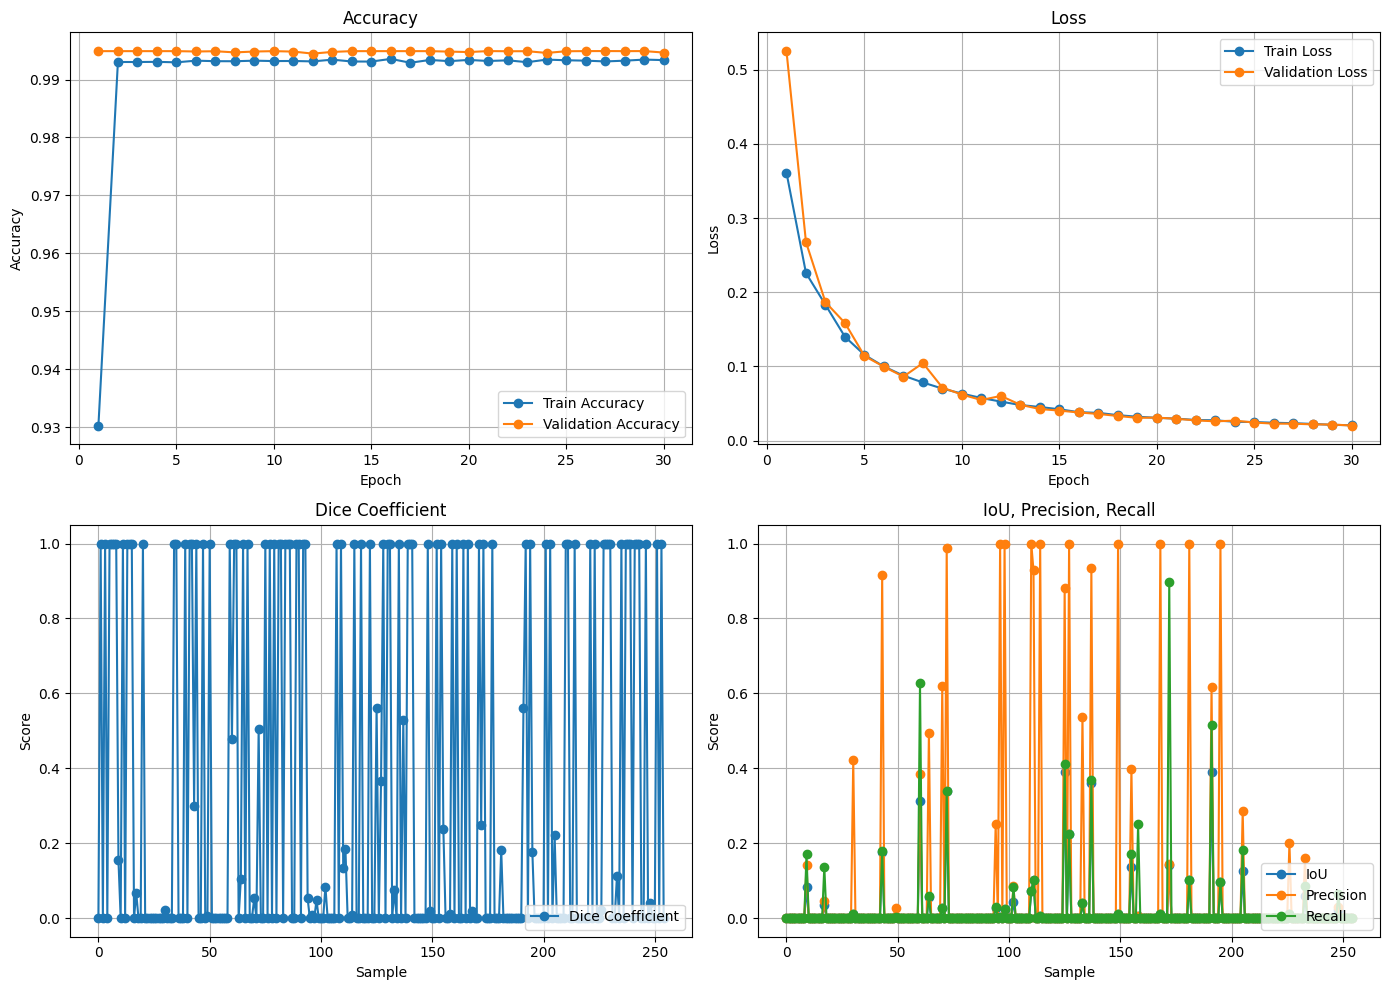

In [27]:
from sklearn.metrics import jaccard_score, precision_score, recall_score
import numpy as np

# Define a Dice coefficient function
def dice_coefficient(y_true, y_pred):
    smooth = 1e-5  # Avoid division by zero
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

# Evaluate model on validation set and compute metrics
y_pred = model.predict(X_val, batch_size=batch_size)
y_pred = (y_pred > 0.5).astype(np.float32)  # Threshold predictions

# Compute metrics
dice_scores = [dice_coefficient(y_val[i], y_pred[i]) for i in range(len(y_val))]
iou_scores = [jaccard_score(y_val[i].flatten(), y_pred[i].flatten()) for i in range(len(y_val))]
precision_scores = [precision_score(y_val[i].flatten(), y_pred[i].flatten()) for i in range(len(y_val))]
recall_scores = [recall_score(y_val[i].flatten(), y_pred[i].flatten()) for i in range(len(y_val))]

# Average metrics
avg_dice = np.mean(dice_scores)
avg_iou = np.mean(iou_scores)
avg_precision = np.mean(precision_scores)
avg_recall = np.mean(recall_scores)

print(f"Average Dice Coefficient: {avg_dice:.4f}")
print(f"Average IoU: {avg_iou:.4f}")
print(f"Average Precision: {avg_precision:.4f}")
print(f"Average Recall: {avg_recall:.4f}")

# Plot metrics
epochs = range(1, len(history.history['accuracy']) + 1)
plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
plt.plot(epochs, history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(epochs, history.history['loss'], label='Train Loss', marker='o')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)

# Plot additional scores
plt.subplot(2, 2, 3)
plt.plot(range(len(dice_scores)), dice_scores, label='Dice Coefficient', marker='o')
plt.title('Dice Coefficient')
plt.xlabel('Sample')
plt.ylabel('Score')
plt.legend(loc='lower right')
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(range(len(iou_scores)), iou_scores, label='IoU', marker='o')
plt.plot(range(len(precision_scores)), precision_scores, label='Precision', marker='o')
plt.plot(range(len(recall_scores)), recall_scores, label='Recall', marker='o')
plt.title('IoU, Precision, Recall')
plt.xlabel('Sample')
plt.ylabel('Score')
plt.legend(loc='lower right')
plt.grid(True)

plt.tight_layout()
plt.show()
